# CMPINF0010: What is the best Pittsburgh Neighborhood?
Team Graffiti

Members: Jared Peters and Zachariah Feerrar

---
# Metric 1: Safety
By Jared Peters

## Introduction

I chose safety as my metric because it is very important to most people.
No matter why you're in the neighborhood, you want to feel secure.
Here, we will determine the safety of each neighborhood by analyzing recent criminal incidents as well as their relative populations. Essentially, we will find the safest neighborhoods by finding those that are the most dangerous.

## Datasets
- [Police Incident Blotter (30 Day)](https://data.wprdc.org/dataset/police-incident-blotter)
> Information on recent criminal incidents including their location and type
- [Pittsburgh American Community Survey 2015 - Total Population](https://data.wprdc.org/dataset/pittsburgh-american-community-survey-2015-miscellaneous-data/resource/82f29015-6905-4b1c-8300-afe9bb2231b3)
> The most recent and complete data that I could find on neighborhood populations.
> Includes population estimates from 2015.

### Step 1: Setup
- Import pandas and matplotlib
- Import blotter dataframe
- Refine dataset columns

In [120]:
import pandas as pd
# % matplotlib inline

In [121]:
# Import online Blotter data
blotter_data = pd.read_csv("https://data.wprdc.org/datastore/dump/1797ead8-8262-41cc-9099-cbc8a161924b")
blotter_data.columns

Index(['PK', 'CCR', 'HIERARCHY', 'INCIDENTTIME', 'INCIDENTLOCATION',
       'CLEAREDFLAG', 'INCIDENTNEIGHBORHOOD', 'INCIDENTZONE',
       'INCIDENTHIERARCHYDESC', 'OFFENSES', 'INCIDENTTRACT',
       'COUNCIL_DISTRICT', 'PUBLIC_WORKS_DIVISION', 'X', 'Y'],
      dtype='object')

There are many columns, but we only need a few.

In [122]:
# Filter out unnecessary columns
blotter_data = blotter_data[['INCIDENTNEIGHBORHOOD', 'INCIDENTHIERARCHYDESC']]
blotter_data.head(10)

,INCIDENTNEIGHBORHOOD,INCIDENTHIERARCHYDESC
0,Strip District,HIT AND RUN
1,Fineview,99
2,East Hills,THEFT
3,Lincoln-Lemington-Belmar,ENDANGER WELFARE OF CHILDREN
4,Westwood,THEFT BY DECEPTION
5,Squirrel Hill South,CRIM MISCHIEF (GRAFFITI)
6,Banksville,99
7,Perry South,THEFT
8,East Liberty,RETSIL THEFT (SHOPLIFTING)
9,Central Business District,FIREARMS NOT TO BE CARRIED WO LICENSE


### Step 2: Determine Danger Level
- Create a function to weigh incidents based on their severity

There are too many incident types to weight each one

In [123]:
# Count the unique incident types
blotter_data['INCIDENTHIERARCHYDESC'].nunique()

99

We can look at the most common and group them by severity

In [124]:
# Let's take the top 15 and group them into categories for their severity
blotter_data['INCIDENTHIERARCHYDESC'].value_counts().head(20)

99                                559
HIT AND RUN                       293
THEFT                             270
SIMPLE ASSAULT                    168
THEFT FROM AUTO                   147
HARRASSMENT                       132
CRIM MISCHIEF                     117
AIDED CASE                         72
HARRASSMENT/THREAT/ATTEMPT/PHY     62
AGG-ASSAULT                        60
STOLEN PROPERTY - OTHER            60
FOUND PROPERTY                     59
BURGLARY                           58
DEAD ON ARRIVAL (DOA)              48
STOLEN PROPERTY                    45
TERRORISTIC THREATS                45
CRIMINAL MISCHIEF                  44
THEFT BY DECEPTION                 44
MENTAL 201/302                     41
MISCELLANEOUS INVESTIGATION        40
Name: INCIDENTHIERARCHYDESC, dtype: int64

Most of them can be seen as moderate, but some are more minor or severe

In [125]:
severe_incidents = ["BURGLARY", "DEAD ON ARRIVAL (DOA)"]
minor_incidents = ["99", "CRIM MISCHIEF", "RETAIL THEFT (SHOPLIFTING)"]
# Any other incidents will be considered moderate

We'll now make a 'DANGER_LEVEL' column to describe the weighted rating of the offense

In [126]:
def get_incident_weight(incident: str):
    if incident in severe_incidents:
        return 150
    if incident in minor_incidents:
        return 75
    return 100

blotter_data['DANGER_LEVEL'] = blotter_data['INCIDENTHIERARCHYDESC'].map(get_incident_weight)
blotter_data.head()

,INCIDENTNEIGHBORHOOD,INCIDENTHIERARCHYDESC,DANGER_LEVEL
0,Strip District,HIT AND RUN,100
1,Fineview,99,75
2,East Hills,THEFT,100
3,Lincoln-Lemington-Belmar,ENDANGER WELFARE OF CHILDREN,100
4,Westwood,THEFT BY DECEPTION,100


Once we have these danger levels, we can group the data by Neighborhood and aggregate by their total danger level.

In [127]:
nb_groups = blotter_data.groupby('INCIDENTNEIGHBORHOOD')
neighborhood_data = nb_groups.agg({'DANGER_LEVEL':'sum'})
neighborhood_data.head()

,DANGER_LEVEL
INCIDENTNEIGHBORHOOD,
Allegheny Center,2500
Allegheny West,700
Allentown,4175
Arlington,2300
Arlington Heights,350


Here are the top 10 safest and most dangerous neighborhoods, based purely on DANGER_LEVEL

<AxesSubplot:xlabel='Safest Neighborhoods', ylabel='Danger per Capita'>

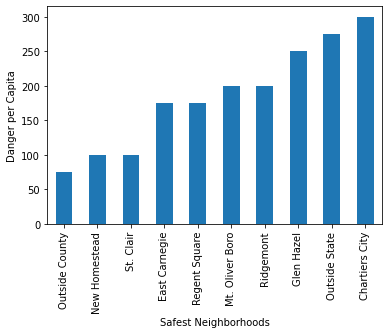

In [128]:
neighborhood_data = neighborhood_data.sort_values(by="DANGER_LEVEL")
neighborhood_data['DANGER_LEVEL'].head(10).plot.bar(xlabel='Safest Neighborhoods', ylabel='Danger per Capita')

<AxesSubplot:xlabel='Most Dangerous Neighborhoods', ylabel='Danger per Capita'>

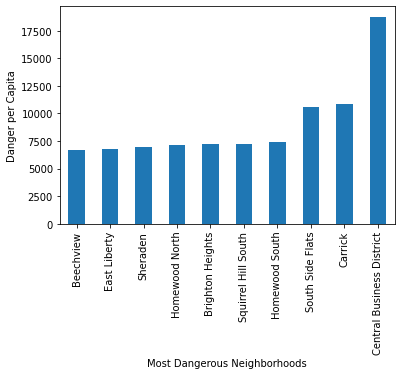

In [129]:
neighborhood_data['DANGER_LEVEL'].tail(10).plot.bar(xlabel="Most Dangerous Neighborhoods", ylabel='Danger per Capita')

## Step 3: Account for Population
This data still may not be a fair indicator, as higher populations will tend to have more crime due to having more people.

We can account for this by importing estimated population data.

In [130]:
population_data = pd.read_csv('https://data.wprdc.org/dataset/5b18c198-474c-4723-b735-cc5220ad43cc/resource/82f29015-6905-4b1c-8300-afe9bb2231b3/download/total-population.csv', index_col='Neighborhood')
population_data.head()

,Id,Estimate; Total,Margin of Error; Total
Neighborhood,,,
Allegheny Center,1,1411.0,196.000000
Allegheny West,2,343.0,96.000000
Allentown,3,2558.0,449.773276
Arlington,4,1852.0,348.188168
Arlington Heights,5,272.0,126.000000


We can add the 'Estimate; Total' data to our current neighborhood data by creating a new column.

In [131]:
neighborhood_data['POPULATION'] = population_data['Estimate; Total']
# Drop any neighborhoods that are missing population data
neighborhood_data = neighborhood_data.dropna()
neighborhood_data.head()

,DANGER_LEVEL,POPULATION
INCIDENTNEIGHBORHOOD,,
New Homestead,100,973.0
St. Clair,100,270.0
East Carnegie,175,610.0
Regent Square,175,1033.0
Ridgemont,200,314.0


Now, we can join our dataframes and create a new column for danger level per capita and sort based on our new values

In [132]:
neighborhood_data['DANGER_PER_CAPITA'] = neighborhood_data['DANGER_LEVEL'] / neighborhood_data['POPULATION']
neighborhood_data = neighborhood_data.sort_values(by="DANGER_PER_CAPITA").dropna()
neighborhood_data.head()

,DANGER_LEVEL,POPULATION,DANGER_PER_CAPITA
INCIDENTNEIGHBORHOOD,,,
New Homestead,100,973.0,0.102775
Regent Square,175,1033.0,0.169409
Squirrel Hill North,2925,11336.0,0.258028
East Carnegie,175,610.0,0.286885
Overbrook,1150,3682.0,0.312330


## Conclusion

This 'DANGER_PER_CAPITA' can be used as our indicator for safety, so let's look at the most and least safe neighborhoods

<AxesSubplot:xlabel='Safest Neighborhoods', ylabel='Danger per Capita'>

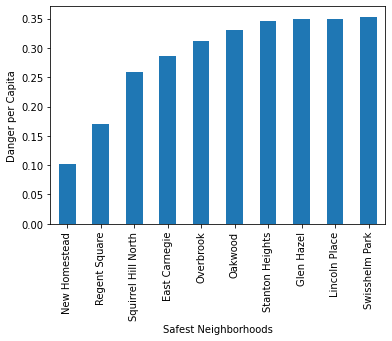

In [133]:
neighborhood_data['DANGER_PER_CAPITA'].head(10).plot.bar(xlabel='Safest Neighborhoods', ylabel='Danger per Capita')

<AxesSubplot:xlabel='Most Dangerous Neighborhoods', ylabel='Danger per Capita'>

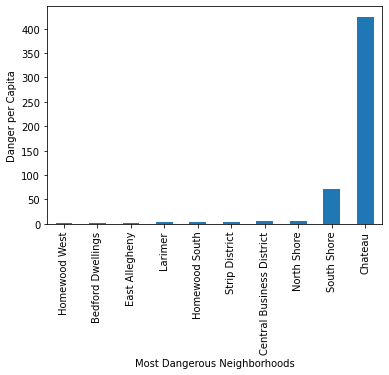

In [134]:
neighborhood_data['DANGER_PER_CAPITA'].tail(10).plot.bar(xlabel="Most Dangerous Neighborhoods", ylabel='Danger per Capita')

### Woah! Why is Chateau's danger rating so high?

![Chateau](https://i.imgur.com/npKt6xa.gif)

Chateau has a very small is population (Only 3, according to our population dataset), and mainly consists of [warehouses](https://en.wikipedia.org/wiki/Chateau_(Pittsburgh)), so it could be possible that people go to this unpopulated neighborhood to stay under the radar and commit crime

In [135]:
neighborhood_data.loc['Chateau']

DANGER_LEVEL         1275.0
POPULATION              3.0
DANGER_PER_CAPITA     425.0
Name: Chateau, dtype: float64

South Shore also similarly has a small population (12) and consists of many warehouses.

In [136]:
neighborhood_data.loc['South Shore']

DANGER_LEVEL         850.000000
POPULATION            12.000000
DANGER_PER_CAPITA     70.833333
Name: South Shore, dtype: float64

Based on calculations including the amount of police incidents reported, the type of incidents, and the neighborhood populations, the final rankings from safest to most dangerous are as follows:

In [137]:
# Print each of the neighborhoods (the index of the df) on separate lines in order
for rank, nb in enumerate(neighborhood_data.index, 1):
    print(f"{rank}. {nb}")

1. New Homestead
2. Regent Square
3. Squirrel Hill North
4. East Carnegie
5. Overbrook
6. Oakwood
7. Stanton Heights
8. Glen Hazel
9. Lincoln Place
10. Swisshelm Park
11. Shadyside
12. St. Clair
13. Greenfield
14. Banksville
15. Squirrel Hill South
16. Bloomfield
17. North Oakland
18. Morningside
19. Brookline
20. Westwood
21. Chartiers City
22. Point Breeze
23. Garfield
24. Spring Garden
25. Highland Park
26. Central Oakland
27. Upper Lawrenceville
28. Mount Washington
29. Ridgemont
30. Lower Lawrenceville
31. Polish Hill
32. Marshall-Shadeland
33. Central Lawrenceville
34. Terrace Village
35. Windgap
36. Duquesne Heights
37. Fairywood
38. Troy Hill
39. Beechview
40. Friendship
41. South Oakland
42. Perry North
43. Upper Hill
44. Summer Hill
45. Spring Hill-City View
46. Crafton Heights
47. Bluff
48. Beltzhoover
49. Brighton Heights
50. Lincoln-Lemington-Belmar
51. South Side Slopes
52. Carrick
53. Elliott
54. Knoxville
55. West Oakland
56. Point Breeze North
57. Sheraden
58. East Lib

---
# Metric 2: Public Art
 By Zachariah Feerrar

## Dataset:
Public art: https://data.wprdc.org/dataset/city-of-pittsburgh-public-art

## Introduction

I chose public art as my metric because it gives a neighborhood life. There is history behind each piece that could be explored too. This can attract more guests, as it something to fill time viewing and exploring. The more art, the more people come in and out. Word can spread about the amount of art in a neighborhood too, giving it more popularity overall.

## Examples
Tree Memorial:

![tree](https://tools.wprdc.org/images/pittsburgh/art_monuments/WM00043000.jpg)

Colonel James Anderson Monument:

![james](https://tools.wprdc.org/images/pittsburgh/art_monuments/WM00001000.jpg)

## Setup

I imported pandas, matplotlib, and the public art dataframe.

In [138]:
#imports
import pandas as pd
#%matplotlib inline
import matplotlib.pyplot as plt

I also filtered the information to only neighborhoods and art types, since those are the only columns we will be using.

In [139]:
#Data is being read through csv file
parks = pd.read_csv("https://data.wprdc.org/datastore/dump/00d74e83-8a23-486e-841b-286e1332a151",
                           index_col="title",
                           parse_dates=True)

#Filter information so it only lists each art project, neighborhood, and art type in Pittsburgh
parks = parks[['neighborhood', 'art_type']]
parks['neighborhood'] = parks['neighborhood'].fillna('Unknown')
parks['art_type'] = parks['art_type'].fillna('Unknown')
parks.head(100)

,neighborhood,art_type
title,,
Oakwood Road Monument,Oakwood,Unknown
Middle East Memorial Plaque,Central Business District,War Memorials
L'Enfant,Carrick,Historic Art
Veterans Memorial (Brookline),Brookline,War Memorials
Oakley Street Mosaic Steps,South Side Slopes,Modern and Contemporary Art
...,...,...
Untitled,Hazelwood,Modern and Contemporary Art
Untitled,Hazelwood,Modern and Contemporary Art
Untitled,Hazelwood,Modern and Contemporary Art


## Determining which neighborhood has the most public art

I started by grouping the neighborhoods and art types together to make a table showing how many times they were used in the dataframe. I also filled the NaN values with 0 so they are included in the dataset.

In [140]:
park = pd.DataFrame(parks.groupby(["neighborhood", "art_type"]).size().unstack().fillna(0))
park

art_type,Historic Art,Individual and Historic Monuments,Modern and Contemporary Art,Non-City Owned,Unknown,War Memorials
neighborhood,,,,,,
Allegheny Center,8.0,4.0,2.0,0.0,0.0,4.0
Allegheny West,0.0,0.0,1.0,0.0,0.0,0.0
Allentown,0.0,0.0,2.0,0.0,0.0,0.0
Beechview,0.0,1.0,1.0,0.0,3.0,3.0
Beltzhoover,0.0,0.0,1.0,0.0,0.0,2.0
Bloomfield,0.0,0.0,0.0,0.0,0.0,1.0
Brighton Heights,0.0,0.0,1.0,0.0,0.0,4.0
Brookline,0.0,1.0,0.0,0.0,0.0,1.0
Carrick,1.0,0.0,1.0,0.0,0.0,1.0


I then made a bar graph, as the information is easier to read. The different colors are for each art type. The art that didn't have a neighborhood or art type is "Unknown" on the graph.

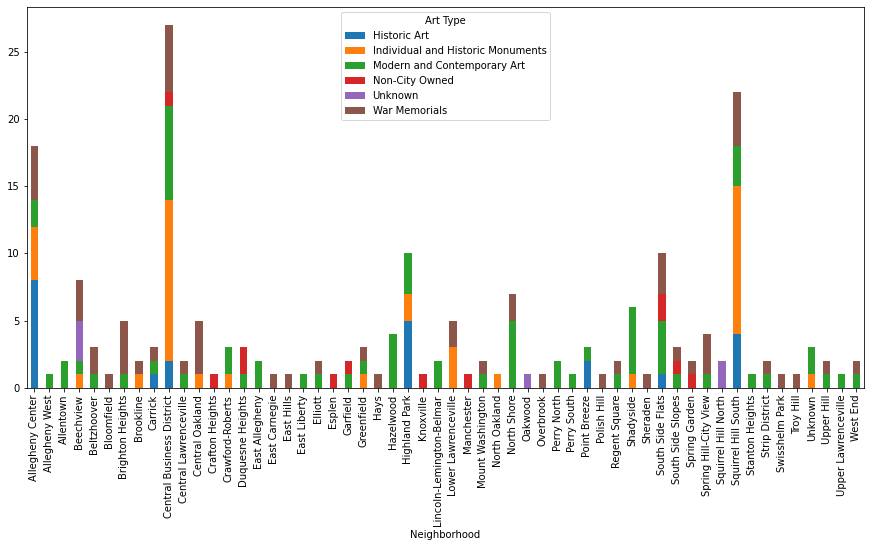

In [141]:
fig, ax = plt.subplots(figsize=(15,7))
park.plot.bar(stacked=True,ax=ax)
plt.xlabel("Neighborhood")
plt.legend(title='Art Type')

## Conclusion
As you can see, Central Business District has the most public art in Pittsburgh. This makes it the best according to my metric. It isn't really surprising, as it is downtown and is visited more frequently by guests.

The "worst" neighborhood is shared by several neighborhoods, such as Hays and Polish Hill, with a shared amount of 1 public art project.

---
# Combining the Data
In order to combine our data, we will create standardized ratings for each metric.

We can do this by dividing each metric's numerical value by their max.

## Safety Rating
We will start by getting a standard rating for the danger of each neighborhood.

Typically, this could be done by dividing each DANGER_PER_CAPITA by the max DANGER_PER_CAPITA, but since we have 2 outliers we will divide by the 3rd largest DANGER_PER_CAPITA.

In [142]:
# The "max" here is actually the 3rd largest, since we want to ignore the outliers
max_danger_per_capita = neighborhood_data["DANGER_PER_CAPITA"][-3]
neighborhood_data["DANGER_RATING"] = neighborhood_data["DANGER_PER_CAPITA"] / max_danger_per_capita

Now to get a rating for safety, we can just take 1 - DANGER_RATING, since the values fall between [0, 1] (other than the outliers)

In [143]:
neighborhood_data["SAFETY_RATING"] = 1 - neighborhood_data["DANGER_RATING"]
neighborhood_data

,DANGER_LEVEL,POPULATION,DANGER_PER_CAPITA,DANGER_RATING,SAFETY_RATING
INCIDENTNEIGHBORHOOD,,,,,
New Homestead,100,973.0,0.102775,0.016207,0.983793
Regent Square,175,1033.0,0.169409,0.026715,0.973285
Squirrel Hill North,2925,11336.0,0.258028,0.040689,0.959311
East Carnegie,175,610.0,0.286885,0.045240,0.954760
Overbrook,1150,3682.0,0.312330,0.049252,0.950748
...,...,...,...,...,...
Strip District,3250,747.0,4.350736,0.686078,0.313922
Central Business District,18775,4060.0,4.624384,0.729230,0.270770
North Shore,1300,205.0,6.341463,1.000000,0.000000


## Art Project Weighting

For each neighborhood, we divided the amount of art projects in that neighborhood by the max amount, which was Central Business District's 27 projects. A column was added to the data table showing the weight of the neighborhoods compared to the best one from that metric.

In [144]:
max_public_art = parks['neighborhood'].value_counts().sort_values(ascending=False)[0]
park['weight'] = parks['neighborhood'].value_counts()/max_public_art
park

art_type,Historic Art,Individual and Historic Monuments,Modern and Contemporary Art,Non-City Owned,Unknown,War Memorials,weight
neighborhood,,,,,,,
Allegheny Center,8.0,4.0,2.0,0.0,0.0,4.0,0.666667
Allegheny West,0.0,0.0,1.0,0.0,0.0,0.0,0.037037
Allentown,0.0,0.0,2.0,0.0,0.0,0.0,0.074074
Beechview,0.0,1.0,1.0,0.0,3.0,3.0,0.296296
Beltzhoover,0.0,0.0,1.0,0.0,0.0,2.0,0.111111
Bloomfield,0.0,0.0,0.0,0.0,0.0,1.0,0.037037
Brighton Heights,0.0,0.0,1.0,0.0,0.0,4.0,0.185185
Brookline,0.0,1.0,0.0,0.0,0.0,1.0,0.074074
Carrick,1.0,0.0,1.0,0.0,0.0,1.0,0.111111


## Making the Final Dataframe
We can now finalize our dataframe with only the art and safety ratings.

Since safety is typically more important when deciding a neighborhood to live in, it will have twice the weight.

In [145]:
final_df = pd.DataFrame(neighborhood_data["SAFETY_RATING"])
final_df['ART_RATING'] = park['weight']
final_df.index = final_df.index.rename("Neighborhood")

# Give any missing values a weight of 0 (Such as those with no data on art)
final_df = final_df.fillna(0)

# We will double every SAFETY_RATING, in order to give it twice as much value
final_df['SAFETY_RATING'] = final_df['SAFETY_RATING'] * 2

# Create a TOTAL_RATING column as a sum of both ratings, with twice the weight on safety
final_df['TOTAL_RATING'] = final_df['SAFETY_RATING'] + final_df['ART_RATING']

# Sort based on the new rating
final_df = final_df.sort_values(by='TOTAL_RATING', ascending=False)

final_df

,SAFETY_RATING,ART_RATING,TOTAL_RATING
Neighborhood,,,
Squirrel Hill South,1.857465,0.814815,2.672280
Highland Park,1.810121,0.370370,2.180491
Shadyside,1.887795,0.222222,2.110017
Allegheny Center,1.441204,0.666667,2.107870
Beechview,1.739392,0.296296,2.035688
...,...,...,...
Homewood South,0.971120,0.000000,0.971120
Strip District,0.627845,0.074074,0.701919
North Shore,0.000000,0.259259,0.259259


# Final Conclusion
## Best Neighborhoods

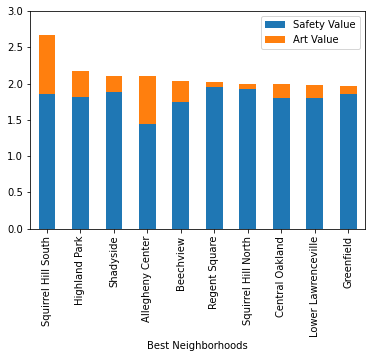

In [146]:
final_df[['SAFETY_RATING', 'ART_RATING']].head(10).plot.bar(stacked=True, ylim=(0, 3), xlabel="Best Neighborhoods").legend(["Safety Value", "Art Value"])

## Worst Neighborhoods

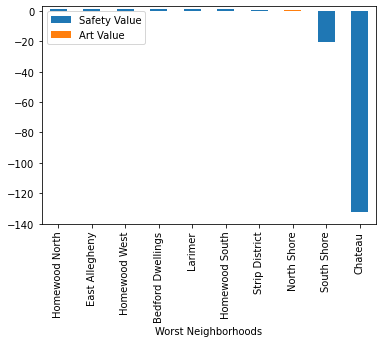

In [147]:
final_df[['SAFETY_RATING', 'ART_RATING']].tail(10).plot.bar(stacked=True, ylim=(-140, 3), xlabel="Worst Neighborhoods").legend(["Safety Value", "Art Value"])

Okay we get it. Chateau and South Shore are really unsafe!

Let's look at the worst neighborhoods other than the outliers.

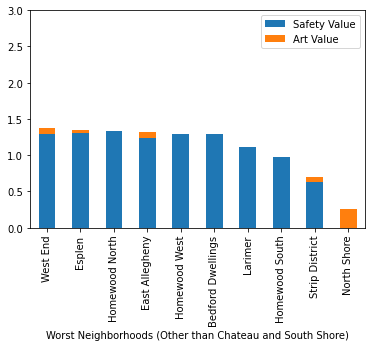

In [148]:
final_df[['SAFETY_RATING', 'ART_RATING']][:-2].tail(10).plot.bar(stacked=True, ylim=(0, 3), xlabel="Worst Neighborhoods (Other than Chateau and South Shore)").legend(["Safety Value", "Art Value"])

Jared: Our data has shown Squirrel Hill South to be the clear winner of "Best Neighborhood". Excelling in both safety and culture, Squirrel Hill South is shown to be a great place for anyone to live, especially those who appreciate public art.
Chateau on the other hand, was shown to be the biggest loser. With a 2015 estimated population of only 3 people, it is clearly not a popular place to live and is probably not a real consideration for many people looking for a place to live. Our data has shown it do be very unsafe and completely lacking in public art. I for one, will avoid it.

Zachariah: Since this is my first year in Pittsburgh, I haven't had the chance to visit every neighborhood yet. I have been to Squirrel Hill South before and I have had good experiences there overall. It is a very safe and beautiful neighborhood, so I can understand why it ranks #1 according to our dataset. I haven't been to North/South Shore or Chateau before, but based on our data I don't think it would be a good idea to visit.

# Full List

In [149]:
# Print each of the neighborhoods (the index of the df) on separate lines in order
for rank, nb in enumerate(final_df.index, 1):
    print(f"{rank}. {nb}")

1. Squirrel Hill South
2. Highland Park
3. Shadyside
4. Allegheny Center
5. Beechview
6. Regent Square
7. Squirrel Hill North
8. Central Oakland
9. Lower Lawrenceville
10. Greenfield
11. New Homestead
12. East Carnegie
13. Overbrook
14. Point Breeze
15. Oakwood
16. Stanton Heights
17. Swisshelm Park
18. Brookline
19. Bloomfield
20. North Oakland
21. Glen Hazel
22. Lincoln Place
23. Garfield
24. Spring Garden
25. St. Clair
26. Duquesne Heights
27. Brighton Heights
28. Mount Washington
29. Spring Hill-City View
30. Central Lawrenceville
31. Banksville
32. Morningside
33. South Side Flats
34. Upper Lawrenceville
35. Westwood
36. Chartiers City
37. Polish Hill
38. Beltzhoover
39. Ridgemont
40. Perry North
41. Upper Hill
42. Marshall-Shadeland
43. Terrace Village
44. Troy Hill
45. South Side Slopes
46. Windgap
47. Carrick
48. Lincoln-Lemington-Belmar
49. Fairywood
50. Hazelwood
51. Crafton Heights
52. Elliott
53. Friendship
54. South Oakland
55. Summer Hill
56. Bluff
57. Knoxville
58. Shera